In [2]:
import warnings
import json

import pandas as pd
import numpy as np
import statsmodels.api as sm # needs weird installation command: arch -x86_64 python3 -m pip install statsmodels

from jre_utils.datapath import (
    factor_data_paths,
    get_derived_csv_path,
    get_derived_lpa_path,
    get_derived_plps_path,
    DATA_DIRECTORY_PATH
)
from jre_utils.config import asset_types
from jre_utils.visualize import plot_time_series

from jp_prefecture.jp_cities import jp_cities as jp

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [3]:
asset_type = "land"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

dataset_paths = {
    "main": get_derived_csv_path(asset_type),
    "lpa": get_derived_lpa_path(),
    "plps": get_derived_plps_path()
}

In [4]:
granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric = metrics["weighted_median"]
metric_pct_chg = metric + "_pct_chg"

In [5]:
core_df_path = dataset_paths["main"]
population_path = factor_data_paths["processed"]["population"]["municipality"]
taxable_income_path = factor_data_paths["processed"]["taxable_income"]["municipality"]
new_dwellings_path = factor_data_paths["processed"]["new_dwellings"]["municipality"]

In [6]:
df = pd.read_csv(core_df_path)

population_df = pd.read_csv(population_path)
taxable_income_df = pd.read_csv(taxable_income_path)
new_dwellings_df = pd.read_csv(new_dwellings_path)

factors = ["taxable_income", "population", "existing_dwellings"]

df = (
    df.merge(
        population_df[group_by_columns + ["population"]],
        on=group_by_columns,
        how="left",
    )
    .merge(
        taxable_income_df[group_by_columns + ["taxable_income"]],
        on=group_by_columns,
        how="left",
    )
    .merge(
        new_dwellings_df[group_by_columns + ["existing_dwellings"]],
        on=group_by_columns,
        how="left",
    )
)

df["area_code"] = df["area_code"].astype(str)

In [7]:
# df

In [8]:
area_to_diff_std = {}

for area_code in df["area_code"].unique():
    area_df = df[df["area_code"] == area_code].sort_values(by="year", ascending=True)
    area_to_diff_std[area_code] = area_df[metric].pct_change().std()


In [9]:
# min_diff_std = min(area_to_diff_std.values())
# max_diff_std = max(area_to_diff_std.values())

# print(min_diff_std, max_diff_std)

area_to_diff_std_series = pd.Series(area_to_diff_std)
min_diff_std = area_to_diff_std_series.quantile(0.05)
max_diff_std = area_to_diff_std_series.quantile(0.95)

print(min_diff_std, max_diff_std)

0.1666693874358655 5.38823000586354


In [10]:
def get_loess_parameters(
    area_code, area_to_diff_std, min_diff_std, max_diff_std, min_frac=0.3, max_frac=0.6
):
    diff_score = (area_to_diff_std[area_code] - min_diff_std) / (
        max_diff_std - min_diff_std
    )
    frac = min_frac + diff_score * (max_frac - min_frac)
    frac = min(frac, 0.8)
    frac = max(frac, 0.1)
    if frac == np.nan:
        frac = 0.1
    return (frac, 3, diff_score)

In [11]:
n = 20
random_area_codes = np.random.choice(df["area_code"].unique(), n)
random_area_codes

array(['46204', '8521', '8309', '20583', '6461', '29444', '1430', '1468',
       '1434', '13120', '4401', '36342', '12230', '3216', '7548', '9411',
       '1664', '10211', '13305', '47301'], dtype=object)

In [12]:
# area_code = "5214" # Akita-ken Nikaho-shi
area_code = "5214"
area_df = df[df["area_code"] == area_code].sort_values(by="year", ascending=True)
# area_df = area_df[area_df["count"] > 1] # Instead, if count == n (where n is small), set value to be average of surrounding values
# area_df

In [14]:
metric = metrics["weighted_median"]
temporal_smoothed_metric_rloess = f"{metric}_smoothed_temporal_rloess"
temporal_smoothed_metric_ma3 = f"{metric}_smoothed_temporal_ma3"

# Identify smooth vs jagged series and use different smoothing parameters

# Robust LOESS
frac, it, diff_score = get_loess_parameters(area_code, area_to_diff_std, min_diff_std, max_diff_std)
print(f"Predicted frac: {frac}, Predicted it: {it}, Diff std: {area_to_diff_std[area_code]}, Diff score: {diff_score}")
# frac = 0.3 # range [0.3, 0.55]
# it = 3

area_df[temporal_smoothed_metric_rloess] = sm.nonparametric.lowess(
    area_df[metric], area_df.index, frac=frac, it=it, return_sorted=False
)

# MA3
area_df[temporal_smoothed_metric_ma3] = area_df[metric].rolling(window=3).mean()

plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False,
)

plot_time_series(
    area_df,
    temporal_smoothed_metric_rloess,
    group_by_columns,
    granularity_columns,
    f"Smoothed Unit Price (Robust LOWESS) over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False,
)

plot_time_series(
    area_df,
    f"{metric}_smoothed",
    group_by_columns,
    granularity_columns,
    f"Smoothed Unit Price (rloess og) over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False,
)


plot_time_series(
    area_df,
    temporal_smoothed_metric_ma3,
    group_by_columns,
    granularity_columns,
    f"Smoothed Unit Price (MA3) over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False,
)


for factor in factors:
    plot_time_series(
        area_df,
        factor,
        group_by_columns,
        granularity_columns,
        f"{factor} over time",
        # visible="legendonly",
        width=1000,
        height=400,
        showlegend=False,
    )

Predicted frac: 0.39688942853191844, Predicted it: 3, Diff std: 1.8530494686499597, Diff score: 0.3229647617730616


# Other Candidates

In [25]:
# ma2
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"
area_df[temporal_smoothed_metric] = area_df[metric].rolling(window=2).mean()


plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

In [26]:
# Weighted moving average
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"

weights = np.array([1, 1, 1]) # [year - 2, year - 1, year]
weights_normalized = weights / np.sum(weights)
area_df[temporal_smoothed_metric] = area_df[metric].rolling(window=3).apply(lambda x: np.dot(x, weights_normalized))

plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

In [27]:
# Double Smoothing
metric = metrics["weighted_median"]
temporal_smoothed_metric_tmp = f"{metric}_smoothed_temporal_tmp"
temporal_smoothed_metric = f"{metric}_smoothed_temporal"
area_df[temporal_smoothed_metric_tmp] = area_df[metric].rolling(window=2).mean()
area_df[temporal_smoothed_metric] = area_df[temporal_smoothed_metric_tmp].rolling(window=2).mean()


plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

In [28]:
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"
area_df[temporal_smoothed_metric] = area_df[metric].ewm(alpha=0.05).mean()

plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

# Experiments

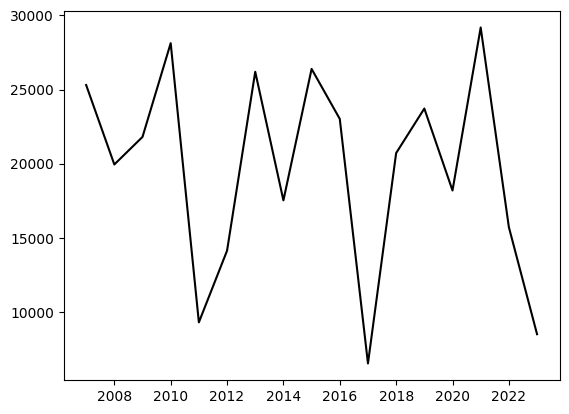

In [29]:
import matplotlib.pyplot as plt

# Fourier Transform
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"

n = len(area_df)
fhat = np.fft.fft(area_df[metric], n)
PSD = fhat * np.conj(fhat) / n
freq = (1 / (n)) * np.arange(n)
L = np.arange(1, np.floor(n / 2), dtype="int")

# plt.plot(freq[L], PSD[L], color="k", label="PSD")

indices = PSD > 1e8
PSDclean = PSD * indices
fhat = indices * fhat
ffilt = np.fft.ifft(fhat)

plt.plot(area_df["year"], ffilt, color="k", label="filtered")

# Verdict - Pretty bad

In [30]:
from scipy.ndimage import convolve
# Two sided smoothing. Convolutions

metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"

filter_coefficients = np.array([0.5, 0.5, 0.5])
smoothed_values = np.convolve(area_df[metric], filter_coefficients, 'valid')

pad_length = len(area_df[metric]) - len(smoothed_values)
padded_smoothed_values = np.pad(smoothed_values, (pad_length, 0), mode='constant', constant_values=np.nan)

area_df[temporal_smoothed_metric] = padded_smoothed_values

plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

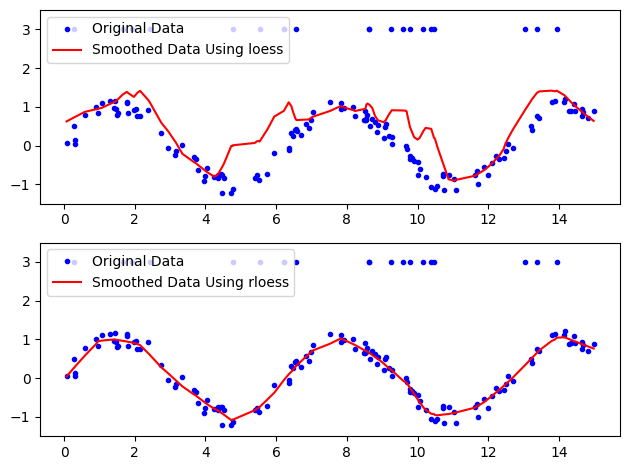

In [39]:
# Set the random seed for reproducibility
np.random.seed(0)

# Generate the data
x = 15 * np.random.rand(150, 1).flatten()
y = np.sin(x) + 0.5 * (np.random.rand(150) - 0.5)
indices = np.random.choice(range(len(x)), size=20, replace=False)
y[indices] = 3  # Introduce outliers

# Smooth the data using LOESS with a span of 10%
# 'loess' is equivalent to it=0 in lowess (no robustness iterations)
# 'rloess' is equivalent to it=3 in lowess (with robustness iterations)
yy1 = sm.nonparametric.lowess(y, x, frac=0.1, it=0, return_sorted=True)
yy2 = sm.nonparametric.lowess(y, x, frac=0.1, it=3, return_sorted=True)


# Sort the data by x for plotting
sorted_indices = np.argsort(x)
sorted_x = x[sorted_indices]
sorted_y = y[sorted_indices]

# Plot original data and the smoothed data using loess
plt.subplot(2, 1, 1)
plt.plot(sorted_x, sorted_y, 'b.', sorted_x, yy1[:, 1], 'r-')
plt.ylim(-1.5, 3.5)
plt.legend(['Original Data', 'Smoothed Data Using loess'], loc='upper left')

# Plot original data and the smoothed data using rloess
plt.subplot(2, 1, 2)
plt.plot(sorted_x, sorted_y, 'b.', sorted_x, yy2[:, 1], 'r-')
plt.ylim(-1.5, 3.5)
plt.legend(['Original Data', 'Smoothed Data Using rloess'], loc='upper left')

plt.tight_layout()
plt.show()

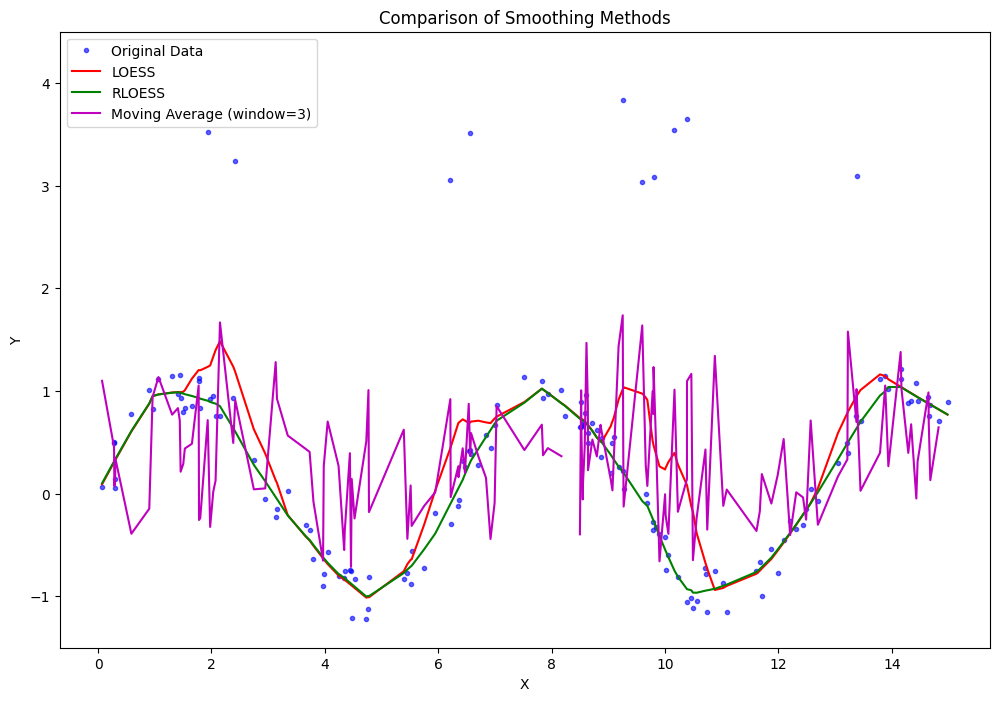

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Set the random seed for reproducibility
np.random.seed(0)

# Generate the data
x = 15 * np.random.rand(150, 1).flatten()
y = np.sin(x) + 0.5 * (np.random.rand(150) - 0.5)

# Introduce outliers by selecting more indices at random
num_outliers = 10  # Number of outliers you want to introduce
outlier_indices = np.random.choice(range(len(x)), size=num_outliers, replace=False)
y[outlier_indices] = 3 + np.random.rand(num_outliers)  # Assign random high values

# Smooth the data using LOESS with a span of 10%
yy1 = lowess(y, x, frac=0.1, it=0, return_sorted=True)
yy2 = lowess(y, x, frac=0.1, it=3, return_sorted=True)

# Sort the data by x for plotting
sorted_indices = np.argsort(x)
sorted_x = x[sorted_indices]
sorted_y = y[sorted_indices]

# Compute the moving average with a window of 3
# Convert y to a pandas Series to use the rolling function
y_series = pd.Series(y)
moving_average_3 = y_series.rolling(window=3, center=True).mean().values

# Plot original data and the smoothed data using loess, rloess, and moving average
plt.figure(figsize=(12, 8))

# Original data
plt.plot(sorted_x, sorted_y, 'b.', alpha=0.6, label='Original Data')

# LOESS
plt.plot(sorted_x, yy1[:, 1], 'r-', label='LOESS')

# RLOESS
plt.plot(sorted_x, yy2[:, 1], 'g-', label='RLOESS')

# Moving Average
plt.plot(sorted_x, moving_average_3[sorted_indices], 'm-', label='Moving Average (window=3)')

plt.ylim(-1.5, 4.5)
plt.legend(loc='upper left')
plt.title('Comparison of Smoothing Methods')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()